<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Specifications for projects

- Tools Used - Jupyter Notebook
- Programming language used - Python
- Additional frameworks and libraries Used - pandas, matplotlib, seaborn, sklearn, numpy


# Problem Statement

- The aim of this project is to use the IMDB Dataset (https://www.kaggle.com/ashirwadsangwan/imdb-dataset) and use data such as actors, director, genre, isAdult and runtime to predict how well a movie will perform. 

- We use the boxoffice and userrating as measures of performance. We will train our model with 80% of the data and test it on the remaining 20%. We will also give our predicitons for upcoming movies that do not have any ratings/boxoffice yet.

- Our hypothesis is that actors & director will positively influence the performance while the variable runtime will negatively influence it. 


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import operator
from sklearn import grid_search
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.svm import SVR  
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge,LinearRegression,Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
import pyspark 
from spark_sklearn import GridSearchCV 
%matplotlib inline



/home/flo/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/grid_search.py:14: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, namedtuple, Sized
/home/flo/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/grid_search.py:14: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, namedtuple, Sized
/home/flo/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/cross_validation.py:37: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be remov

# inital merge to check for NAN

In [ ]:
def join_another(df1,df2, on_col):
    df1['tconst'] = df1['tconst'].astype(str)
    df2['tconst'] = df2['tconst'].astype(str)
    return pd.merge(df1,df2,on=on_col,how="inner")

df = pd.read_csv("./data/boxOffice.csv")

fileNames = [
    'title.basics.tsv',
    'title.crew.tsv',
    "title.principals.tsv",
    "title.ratings.tsv"
    ]
for fileName in fileNames:
    df_to_join = pd.read_csv("./data/"+fileName, sep='\t')
    df = join_another(df,df_to_join,'tconst')

df_to_join = pd.read_csv("./data/name.basics.tsv", sep='\t')
df = pd.merge(df,df_to_join,how='inner',on="nconst")
df_to_join.rename(columns={"nconst":'directors'}, inplace=True)
df = pd.merge(df,df_to_join,how='inner',on=["directors"])
df = df.rename(columns={"primaryName_x":"actor_name","primaryName_y":"director_name"})
df.to_csv("data/allData_unprocessed.csv",index=False)


C:\Users\Ben\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
missing_data_ratio = (np.sum(df.isna())/df.shape[0]).sort_values(ascending=False)
print(missing_data_ratio[missing_data_ratio!=0].count())
missing_data_ratio = missing_data_ratio[missing_data_ratio!=0]
sns.set_theme(style="darkgrid")
sns.barplot(x = missing_data_ratio.index, y=missing_data_ratio.values)

Notes:
    - 3 columns contain missing values
    - domestic contains the most

# 1. Load Data and Preprocessing
Our total used dataset consisists of six subsets and an additional Box office data set which we scraped from the web. 
In this step we are preprocessing and cleaning all these datasets seperately before we join them to one final dataset which we can further use to analyze the data. 

## 1.1 Preprocessing subsets

### title basics
Dataset which gives some basic information about movies such as Title, startYear, runtimeMinutes and genres. 

Following steps were taken into preprocessing this dataset:  
- Drop column 'endYear' since there is no usable data in the column 
- Converting 'startYear', 'isAdult', 'runtimeMinutes' to integers 
- Reducing the dataset by just considering movies between the startyears 2000 - 2020 


In [ ]:
df = pd.read_csv("data/title.basics.tsv",sep="\t")
# Select all non tv Series
df = df[(df['endYear']=='\\N')]
df.drop(["endYear"],axis=1,inplace=True)
df = df[(df['titleType']=="movie")]
# replace all \N with NAN and subsequently drop them
df.replace("\\N",np.nan,inplace=True)
df.dropna(inplace=True)
# Convert data types to int where feasible
df['startYear'] = df['startYear'].astype(int)
df['isAdult'] = df['isAdult'].astype(int)
df['runtimeMinutes'] = df['runtimeMinutes'].astype(int)

df = df[(df['startYear']>=2000) & (df['startYear']<=2020)]

df.reset_index(inplace=True,drop=True)
df.to_csv("data/title.basics_preprocessed.csv",index=False)
df

### title crew

Following steps were taken into preprocessing this dataset:  
- Drop column 'writers' 
- used to merge titles with directors

In [7]:

print(os.getcwd())
print(os.listdir('./data'))
df = pd.read_csv('./data/title.crew.tsv', sep= '\t', header=0)
df.drop(['writers'], axis=1, inplace=True)
print(df['directors'].isnull().values.any())
df.to_csv("data/title.crew_preprocessed.csv",index=False)
df

C:\Users\Joe\Documents\GitHub\BigDataAnalytics
['allData.csv', 'allData_preprocessed.csv', 'allData_unprocessed.csv', 'boxOffice.csv', 'boxOffice_preprocessed.csv', 'name.basics.tsv', 'name.basics_preprocessed.csv', 'nominated_directors.csv', 'README.md', 'tconsts.csv', 'title.akas.tsv', 'title.basics.tsv', 'title.basics_preprocessed.csv', 'title.crew.tsv', 'title.crew_preprocessed.csv', 'title.principals.tsv', 'title.principals_preprocessed.csv', 'title.ratings.csv', 'title.ratings.tsv', 'title.ratings_preprocessed.csv', 'top_actors.csv']
False


,tconst,directors
0,tt0000001,nm0005690
1,tt0000002,nm0721526
2,tt0000003,nm0721526
3,tt0000004,nm0721526
4,tt0000005,nm0005690
...,...,...
7890892,tt9916848,"nm5519375,nm5519454"
7890893,tt9916850,"nm5519375,nm5519454"
7890894,tt9916852,"nm5519454,nm5519375"
7890895,tt9916856,nm10538645


### title akas

In [8]:
df = pd.read_csv("data/title.akas.tsv","\t",usecols=['titleId','language','isOriginalTitle'])
df

C:\Users\Joe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,titleId,language,isOriginalTitle
0,tt0000001,\N,0
1,tt0000001,\N,0
2,tt0000001,\N,0
3,tt0000001,\N,0
4,tt0000001,\N,0
...,...,...,...
26229737,tt9916852,ja,0
26229738,tt9916852,pt,0
26229739,tt9916852,it,0
26229740,tt9916852,hi,0


In [9]:
df = df[df["isOriginalTitle"]==1]
np.unique(df["language"])

array(['\\N', 'ca', 'da', 'en', 'ja'], dtype=object)

### name basics 
This dataset provides different detailed information about the actors such as birthYear, knownForTitlese etc.  

Following steps were taken into preprocessing this dataset:  
- Drop column 'birthYear', 'deathYear', 'primaryProfession', 'knownForTitles' since these data points don't seem to be important in order to predict the success of a movie

In [10]:
df = pd.read_csv("data/name.basics.tsv",sep="\t")
# Drop unnecessary columns
df.drop(["birthYear", "deathYear","primaryProfession","knownForTitles"],axis=1,inplace=True)
# replace all \N with NAN and subsequently drop them
df.replace("\\N",np.nan,inplace=True)
df.dropna(inplace=True)

df.reset_index(inplace=True,drop=True)
df.to_csv("data/name.basics_preprocessed.csv",index=False)
df

,nconst,primaryName
0,nm0000001,Fred Astaire
1,nm0000002,Lauren Bacall
2,nm0000003,Brigitte Bardot
3,nm0000004,John Belushi
4,nm0000005,Ingmar Bergman
...,...,...
10918985,nm9993714,Romeo del Rosario
10918986,nm9993716,Essias Loberg
10918987,nm9993717,Harikrishnan Rajan
10918988,nm9993718,Aayush Nair


### title principals

Following steps were taken into preprocessing this dataset: 
- drop columns 'ordering', 'category', 'job', 'characters' because we assume they are irrelevant for our analysis
- used to merge titles with actors

In [11]:
df = pd.read_csv("data/title.principals.tsv",sep="\t")
# Drop unnecessary columns
df.drop(["ordering", "category","job","characters"],axis=1,inplace=True)
# replace all \N with NAN and subsequently drop them
df.replace("\\N",np.nan,inplace=True)
df.dropna(inplace=True)

df.reset_index(inplace=True,drop=True)
df.to_csv("data/title.principals_preprocessed.csv",index=False)
df

,tconst,nconst
0,tt0000001,nm1588970
1,tt0000001,nm0005690
2,tt0000001,nm0374658
3,tt0000002,nm0721526
4,tt0000002,nm1335271
...,...,...
44636296,tt9916880,nm0996406
44636297,tt9916880,nm1482639
44636298,tt9916880,nm2586970
44636299,tt9916880,nm1594058


### title ratings
This Dataset shows the user ratings of the different movies. 

Following steps were taken into preprocessing this dataset: 
- Drop colum 'numVotes'

In [37]:
df = pd.read_csv("data/title.ratings.tsv", sep ="\t")
# Drop unnecessary columns
df.drop(["numVotes"], axis = 1, inplace = True)
df.dropna(inplace = True)

df.reset_index(inplace=True, drop=True)
df.to_csv("data/title.ratings_preprocessed.csv", index=False)
df

KeyError: "['numVotes'] not found in axis"

### Box Office Data

- scraped from boxofficemojo.com
- dropped each row that contains three NaN's (most row's contain two)
- we only consider worldwide for our analysis

In [13]:
df = pd.read_csv("data/boxOffice.csv")
df.dropna(how="all",subset=["domestic","international","worldwide"],inplace=True)
df.reset_index(inplace=True,drop=True)
df.to_csv("data/boxOffice_preprocessed.csv",index=False)
df

,tconst,domestic,international,worldwide
0,tt0035423,47121859.0,28897189.0,76019048.0
1,tt0100275,3624.0,NaN,3624.0
2,tt0110476,NaN,2139115.0,2139115.0
3,tt0113026,49666.0,NaN,49666.0
4,tt0116748,45200.0,NaN,45200.0
...,...,...,...,...
35671,tt9896916,1294596.0,1878686.0,3173282.0
35672,tt9897528,NaN,3438.0,3438.0
35673,tt9900398,NaN,192989.0,192989.0
35674,tt9900782,NaN,524061.0,524061.0


## 1.2 Joining Data
Joining all the preprocessed datasets from above to one final dataset

In [3]:
def join_another(df1,df2, on_col):
    df1['tconst'] = df1['tconst'].astype(str)
    df2['tconst'] = df2['tconst'].astype(str)
    return pd.merge(df1,df2,on=on_col,how="inner")


df = pd.read_csv("data/boxOffice_preprocessed.csv")

fileNames = [
    'title.basics_preprocessed.csv',
    'title.crew_preprocessed.csv',
    "title.principals_preprocessed.csv",
    "title.ratings_preprocessed.csv"
    ]
for fileName in fileNames:
    df_to_join = pd.read_csv("data/"+fileName)
    df = join_another(df,df_to_join,'tconst')

df_to_join = pd.read_csv("data/name.basics_preprocessed.csv")
df = pd.merge(df,df_to_join,how='inner',on="nconst")
df_to_join.rename(columns={"nconst":'directors'}, inplace=True)
df = pd.merge(df,df_to_join,how='inner',on=["directors"])
df = df.rename(columns={"primaryName_x":"actor_name","primaryName_y":"director_name"})
df.to_csv("data/allData.csv",index=False)
df


FileNotFoundError: [Errno 2] No such file or directory: 'data/title.crew_preprocessed.csv'

# 2. Analyze whole data set

In [7]:
df = pd.read_csv("data/allData.csv")
df.head()

,Unnamed: 0,tconst,domestic,international,worldwide,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,directors,nconst,averageRating,actor_name,director_name
0,0,tt0035423,47121859.0,28897189.0,76019048.0,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance",nm0003506,nm0107463,6.4,David Brenner,James Mangold
1,1,tt0309698,52159536.0,38100000.0,90259536.0,movie,Identity,Identity,0,2003,90,"Mystery,Thriller",nm0003506,nm0107463,7.3,David Brenner,James Mangold
2,2,tt0035423,47121859.0,28897189.0,76019048.0,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance",nm0003506,nm0000212,6.4,Meg Ryan,James Mangold
3,3,tt0035423,47121859.0,28897189.0,76019048.0,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance",nm0003506,nm0413168,6.4,Hugh Jackman,James Mangold
4,4,tt1430132,132556852.0,282271394.0,414828246.0,movie,The Wolverine,The Wolverine,0,2013,126,"Action,Sci-Fi",nm0003506,nm0413168,6.7,Hugh Jackman,James Mangold


## 2 .1 Feature Description
### Continuous Features:
#### domestic, international, worldwide 
- values between 13 and 2847246203

#### runtimeMinutes
- values between 45 and 808

#### averageRating
- values between 1 and 9.8

### Categorical Features:
#### genres
- 23 different categories, plan to apply one-hot-encoding

#### actor_name, director_name
- 143108 actors 17272 directors
- plan to gather data on most popular actors/directors and apply binary feature if they are involved with the film.

### Binary Features:
#### isAdult
- only 46 films set to True, therefore plan on dropping feature

### Mean Boxoffice (worldwide) per year and distribution of amount of films over the years

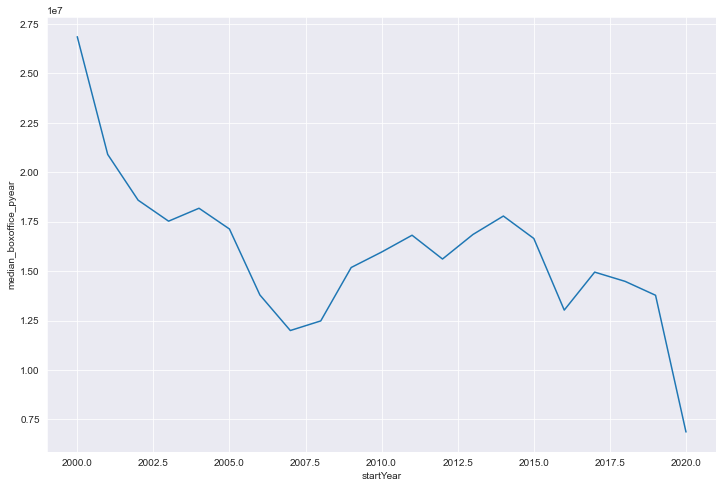

C:\Users\Ben\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


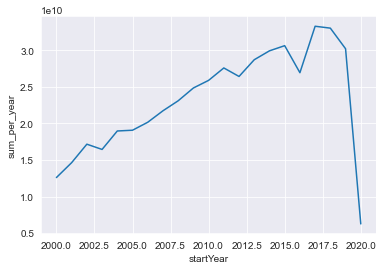

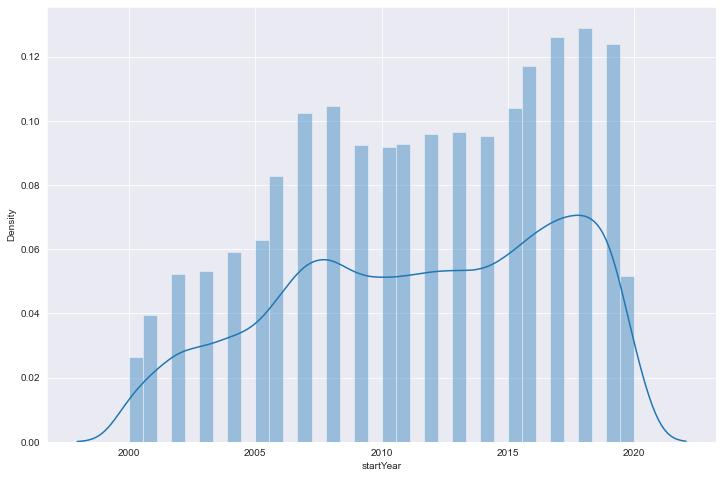

C:\Users\Ben\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


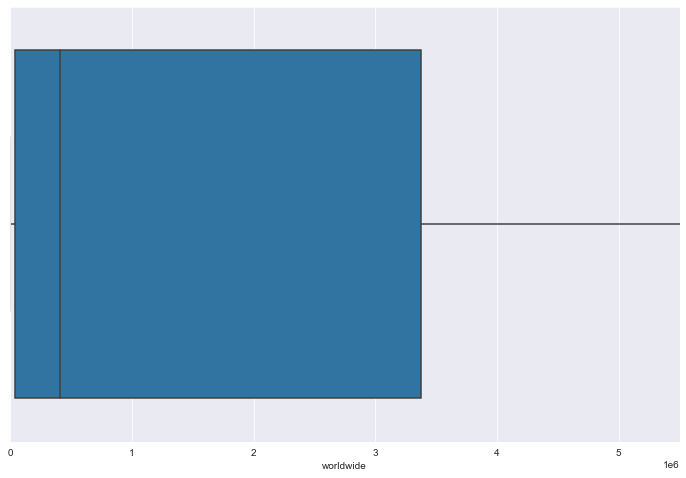

In [26]:
boxoffice_df = df.copy()
boxoffice_df.dropna(inplace=True)
year_boxoffice = boxoffice_df.groupby(boxoffice_df['startYear'].sort_values())['worldwide'].transform('mean')
boxoffice_df['median_boxoffice_pyear'] = year_boxoffice
graphdata = boxoffice_df[['startYear','median_boxoffice_pyear']].drop_duplicates().sort_values('startYear')

sns.set_style("darkgrid")
plt.figure(figsize=(12,8))
sns.lineplot(x=graphdata['startYear'], y=graphdata['median_boxoffice_pyear'])
plt.show()

sum_per_year = boxoffice_df.groupby(boxoffice_df['startYear'].sort_values())['worldwide'].transform('sum')
boxoffice_df['sum_per_year'] = sum_per_year
graphdata2 = boxoffice_df[['startYear','sum_per_year']].drop_duplicates().sort_values('startYear')
sns.lineplot(x=graphdata2['startYear'], y=graphdata2['sum_per_year'])

plt.figure(figsize=(12,8))
sns.distplot(boxoffice_df['startYear'])
plt.show()

plt.figure(figsize=(12,8))
sns.boxplot(boxoffice_df['worldwide'])
plt.xlim(0,5500000)
plt.show()

#### Comments Graph above
- Mean trend seems to go downwards.
    - We speculate that the increase in movie volume after 2015 decreases the average boxoffice per film. 
    - Potentially the rise of streaming platforms have decreased what the films score at the boxoffice. 
    - We will take this into consideration when choosing the test-dataset

### Runtimes of movies displayed

C:\Users\Ben\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


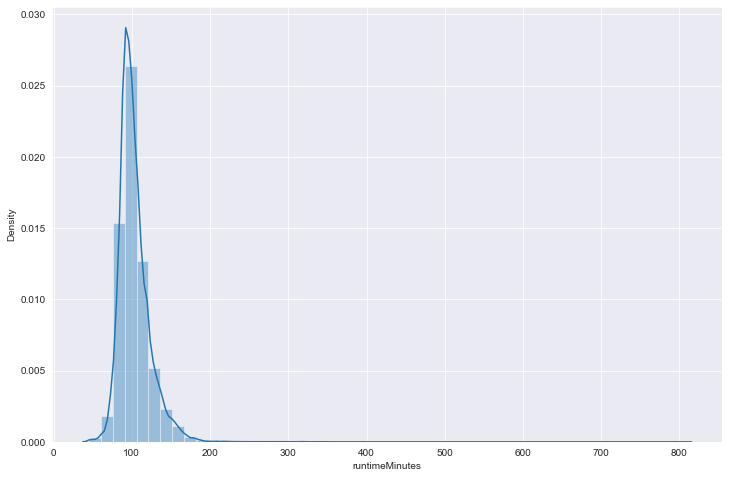

C:\Users\Ben\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


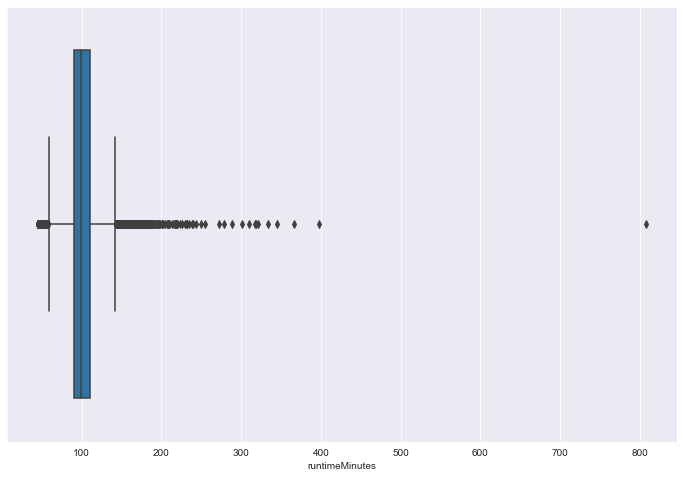

          tconst  worldwide primaryTitle  startYear  runtimeMinutes  \
25873  tt9047474     4032.0      La Flor       2016             808   

       averageRating  Animation  Action  Sci-Fi  Fantasy  ...  News  Sport  \
25873            7.6          0       0       0        0  ...     0      0   

       Biography  Thriller  Drama  War  Musical  Documentary  has_good_actor  \
25873          0         0      0    0        0            0               0   

       has_good_director  
25873                  0  

[1 rows x 31 columns]


In [27]:
plt.figure(figsize=(12,8))
sns.distplot(boxoffice_df['runtimeMinutes'])
plt.show()

plt.figure(figsize=(12,8))
sns.boxplot(boxoffice_df['runtimeMinutes'])
plt.show()
print(df[df['runtimeMinutes'] > 700])

#### Comments on Runtime
- Most films are in the range of 80-120 minutes as expected
- if you plan on spending 13 hours watching a musical, go watch "La Flor"

## 2.2 Feature Engineering 

### One hot encode genres

- Since we want to use the feature genre for our models we use one-hot-encoding.
- One-hot-encoding maps the genres to a column each & sets the row to true if it applies.

In [8]:

genres = np.unique(df['genres'])
genreset = set()
for genre in genres:
    for g in genre.split(","):
        genreset.add(g)

print(genreset)
print(len(genreset))
for i in genreset:
    df[i] = 0


for index,row in enumerate(df['genres']):
    for genre in row.split(','):
        df.at[index,genre] = 1

{'Music', 'Adult', 'Drama', 'Animation', 'Musical', 'Romance', 'History', 'Documentary', 'Sci-Fi', 'Fantasy', 'Horror', 'Western', 'Action', 'Mystery', 'Thriller', 'Biography', 'Adventure', 'Crime', 'Comedy', 'War', 'News', 'Family', 'Sport'}
23


In [50]:
unique_tconst= df['tconst'].unique()
best_actors = pd.read_csv("./data/top_actors.csv")
best_directors = pd.read_csv('./data/nominated_directors.csv')

In [51]:
df['has_good_actor'] = 0
df['has_good_director'] = 0
best_actors = best_actors['top_actors'].to_list()
best_directors = best_directors['nominated_directors'].to_list()

In [52]:
#bad implementation, don't run it
for const in range(len(unique_tconst)):
    print(const)
    df2 = df[df['tconst'] == unique_tconst[const]]
    found_actor=0
    found_director=0
    for i in df2.index:
        if found_actor and found_director:
            break
        if not found_actor and df2.at[i,'actor_name'] in best_actors:
            found_actor=1
        if not found_director and df2.at[i,'director_name'] in best_directors:
            found_director=1
    df.loc[df2.index, 'has_good_actor'] = found_actor
    df.loc[df2.index, 'has_good_director']=found_director
    

5
28466
28467
28468
28469
28470
28471
28472
28473
28474
28475
28476
28477
28478
28479
28480
28481
28482
28483
28484
28485
28486
28487
28488
28489
28490
28491
28492
28493
28494
28495
28496
28497
28498
28499
28500
28501
28502
28503
28504
28505
28506
28507
28508
28509
28510
28511
28512
28513
28514
28515
28516
28517
28518
28519
28520
28521
28522
28523
28524
28525
28526
28527
28528
28529
28530
28531
28532
28533
28534
28535
28536
28537
28538
28539
28540
28541
28542
28543
28544
28545
28546
28547
28548
28549
28550
28551
28552
28553
28554
28555
28556
28557
28558
28559
28560
28561
28562
28563
28564
28565
28566
28567
28568
28569
28570
28571
28572
28573
28574
28575
28576
28577
28578
28579
28580
28581
28582
28583
28584
28585
28586
28587
28588
28589
28590
28591
28592
28593
28594
28595
28596
28597
28598
28599
28600
28601
28602
28603
28604
28605
28606
28607
28608
28609
28610
28611
28612
28613
28614
28615
28616
28617
28618
28619
28620
28621
28622
28623
28624
28625
28626
28627
28628
28629
28630
28631
28

In [54]:
df.to_csv("./data/allData_safety.csv")

In [55]:
# drop duplicate rows
df.drop_duplicates(subset='tconst', inplace=True,ignore_index=True)


In [57]:
# final drop of columns which are unusuable for our models. (dropping isAdult, since only ~40 rows are considered True)
df.drop(["domestic","international","titleType","genres","directors","nconst","actor_name","isAdult","originalTitle","director_name"],axis=1,inplace=True)


In [3]:
df.to_csv("data/allData_preprocessed.csv",index=False)

NameError: name 'df' is not defined

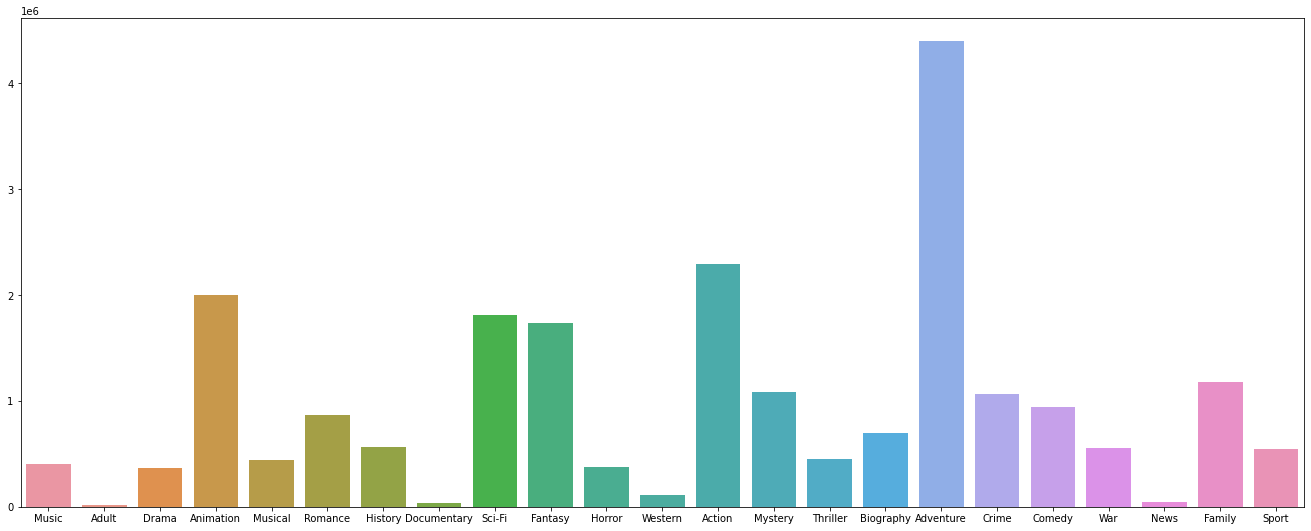

In [10]:
genre_boxoffice = {}

for genre in genreset:
    genre_boxoffice[genre] = df.loc[df[genre] == 1]['worldwide'].median()

import operator
keys = list(genre_boxoffice.keys())
vals = [(genre_boxoffice[k]) for k in keys]
plt.figure(figsize=(23,9))
sns.barplot(x=keys,y=vals)
plt.show()


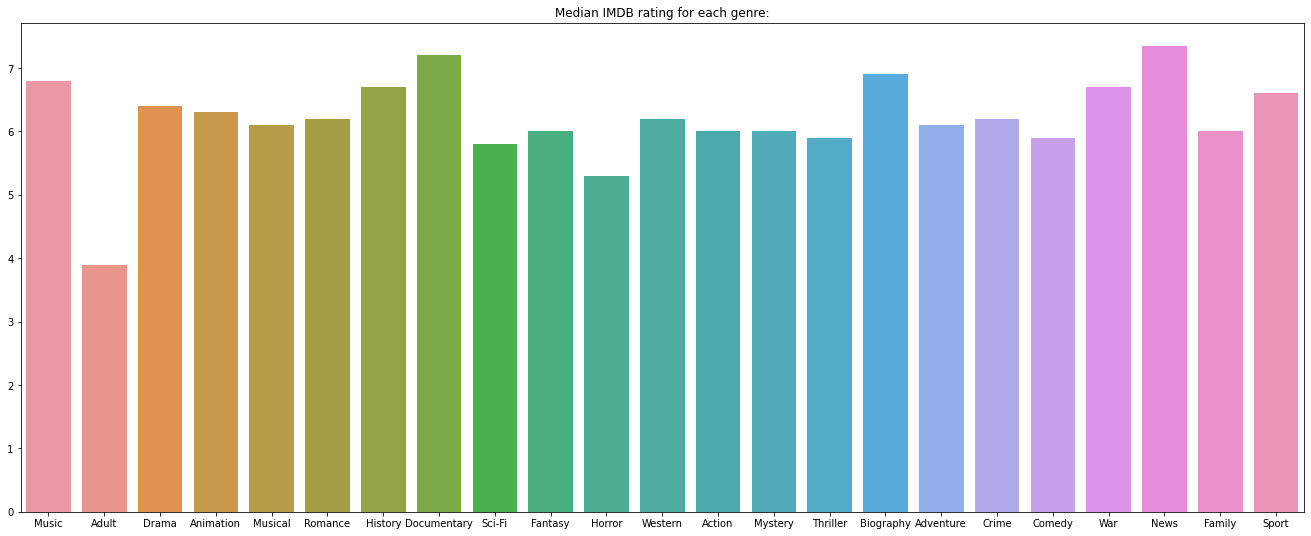

In [11]:


genre_averageRating = {}

for genre in genreset:
    genre_averageRating[genre] = df.loc[df[genre] == 1]['averageRating'].median()

keys = list(genre_averageRating.keys())
vals = [(genre_averageRating[k]) for k in keys]
plt.figure(figsize=(23,9))
sns.barplot(x=keys,y=vals)
plt.title("Median IMDB rating for each genre:")
plt.show()


(31799, 32)
[946, 3, 17122, 1068, 365, 4908, 1156, 3145, 759, 1337, 2123, 90, 4230, 1713, 3523, 1657, 2450, 3435, 10809, 512, 34, 1668, 610]


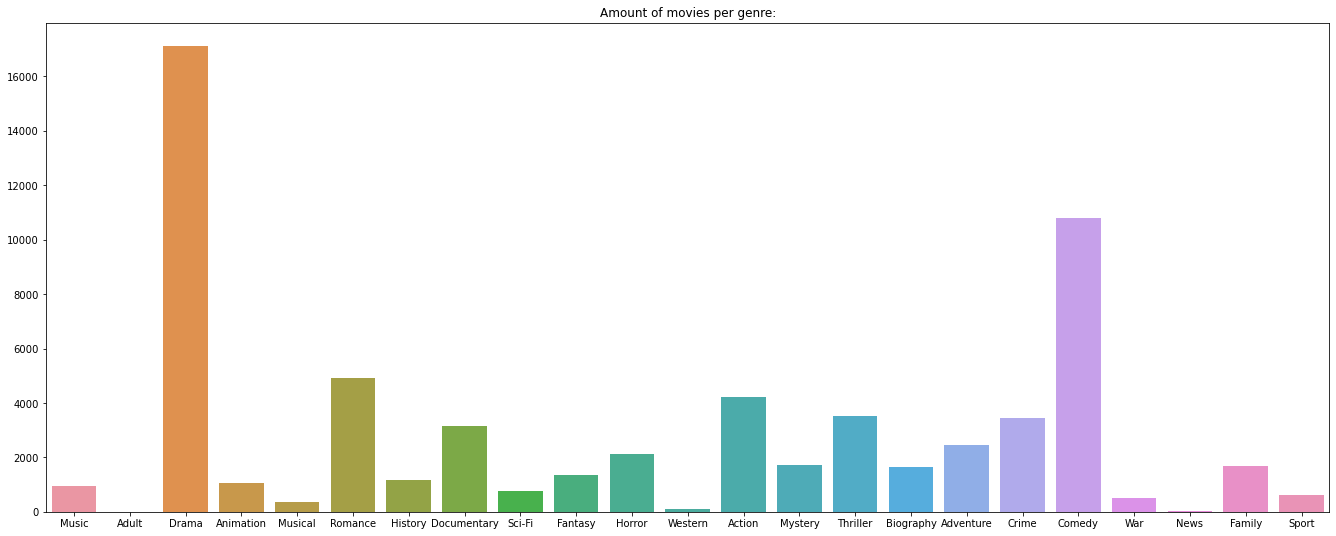

In [12]:

genre_count = {}

print(df.shape)

for genre in genreset:
    genre_count[genre] = len(df[df[genre]==1].index)

keys = list(genre_count.keys())
vals = [(genre_count[k]) for k in keys]
print(vals)
plt.figure(figsize=(23,9))
sns.barplot(x=keys,y=vals)
plt.title("Amount of movies per genre:")
plt.show()

## 2.3 Correlation

<AxesSubplot:>

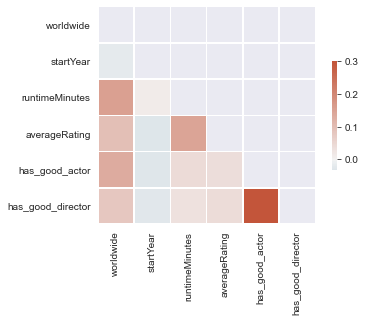

In [29]:
corr = df[['worldwide','startYear','runtimeMinutes','averageRating','has_good_actor','has_good_director']].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


### Comments to Correlation:
- as expected movies with "good" directors are highly correlated with movies with "good" actors
- a good actor seems to correlate more strongly to the boxoffice than the director does.
- there is somewhat a correlation between runtime and boxoffice. We assume that short movies do not score highly at the boxoffice. 
- It seems neither actors or directors have an influence on the averageRating score.

# 3. Model Implementation

We are going to implement following regression models.  

 - Linear Regression
 - Ridge Regression
 - Random Forest


In [2]:
df = pd.read_csv("data/allData_preprocessed.csv")

In [3]:
df.drop("Unnamed: 0",axis=1,inplace=True)

## 3.1 define training, validation & test data

- set averagerating and log(worldwide) as our target predictions. 
    - apply log to worldwide to transform right-skewed data to normal distribution

- apply 80/20 split to dataset for our training/test data

/home/flo/anaconda3/envs/datascience/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
          worldwide  runtimeMinutes       Musical         Sport       Western  \
count  3.179900e+04    31799.000000  31799.000000  31799.000000  31799.000000   
mean   1.532912e+07      102.931727      0.011478      0.019183      0.002830   
std    7.381217e+07       19.898615      0.106522      0.137170      0.053126   
min    1.300000e+01       45.000000      0.000000      0.000000      0.000000   
25%    4.359400e+04       90.000000      0.000000      0.000000      0.000000   
50%    4.096040e+05       99.000000      0.000000      0.000000      0.000000   
75%    3.378874e+06      111.000000      0.000000      0.000000      0.000000   
max   

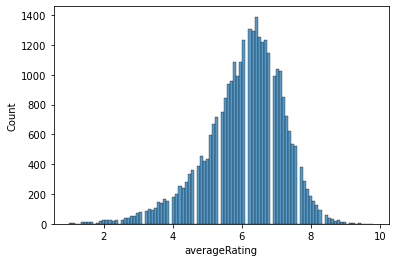

In [12]:
X = df.loc[:, df.columns != 'averageRating']
X.drop(["primaryTitle","tconst","startYear"],axis=1,inplace=True) 
X.drop(["News"],axis=1,inplace=True)
y = df["averageRating"]

#X["worldwide"] = np.log(X["worldwide"])
sns.histplot(y)
print(X.describe())
columns = X.columns
X = X.to_numpy()
y = y.to_numpy()
Xtrain,Xtest, ytrain,ytest = train_test_split(X,y,shuffle=True,train_size=0.8)

## 3.2 Kfold to decrease potential overfitting

In [13]:
def kfold_validation(X,y,model,n_splits=5):
    start = time.time()
    kf = KFold(n_splits=n_splits,shuffle=True, random_state=69420) 
    mses = []
    models = []
    count = 0
    for trainIndices,testIndices in kf.split(X):
        print(f"iteration: {count}")
        Xtrain,Xval = X[trainIndices,:],X[testIndices,:]
        ytrain,yval = y[trainIndices],y[testIndices]
        model.fit(Xtrain,ytrain)
        yhat = model.predict(Xval)
        mse = np.sum(np.square(yval-yhat))/yval.size # mean squared error
        mses.append(mse)
        models.append(model)
        count+=1
    print(f"time used (seconds): {time.time()-start}")
    return mses, models


## 3.3 Standardise to make data more comparable

In [15]:
def standardise_data(X):
    mean = np.mean(X)
    std = np.std(X)
    X_std = (X-mean)/std
    return X_std, mean, std

Xtrain, X_train_mean, X_train_std_div = standardise_data(Xtrain)
Xtest = (Xtest-X_train_mean)/X_train_std_div


In [115]:
def expand_basis(X, degree):
    poly = PolynomialFeatures(degree,interaction_only=True)
    X = poly.fit_transform(X)
    return X 
def prepare_data(X1, degree): 
    scaler = StandardScaler() 
    scaler.fit(X1)
    X1 = expand_basis(scaler.transform(X1),degree) 
    return X1

In [116]:
Xtrain = expand_basis(Xtrain,2)
Xtest = expand_basis(Xtest,2)

In [11]:
print(np.min(y), np.mean(y),np.max(y))

2.5649493574615367 12.912576625425698 21.76961811955037


## 3.4 Linear Regression

In [16]:
model = LinearRegression()
mses,models = kfold_validation(Xtrain,ytrain,model,5)
yhat=models[np.argmin(mses)].predict(Xtest)
np.mean(np.square(yhat-ytest))

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.08749604225158691
/home/flo/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/model_selection/_split.py:428: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = (n_samples // n_splits) * np.ones(n_splits, dtype=np.int)
/home/flo/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/model_selection/_split.py:108: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself

0.9958080543367068

(0.0, 10.0)

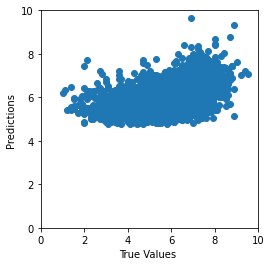

In [19]:
g=plt.scatter(ytest, yhat)
g.axes.set_xlabel('True Values ')
g.axes.set_ylabel('Predictions ')
g.axes.axis('equal')
g.axes.axis('square')
plt.ylim([0,  10])
plt.xlim([0,  10])

## 3.5 Ridge Regression

In [120]:


alphaList = [0.0001,0.001,0.01,0.1,1,10,100]
results = []
for alpha in alphaList:
    model = Ridge(alpha=alpha)
    mses,models = kfold_validation(Xtrain,ytrain,model,5)
    yhat=models[np.argmin(mses)].predict(Xtest)
    results.append(np.mean(np.square(yhat-ytest)))
    
print(results)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 1.3194992542266846
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 1.420501470565796
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 1.3570032119750977
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 1.3740012645721436
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 1.51100492477417
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 1.7115018367767334
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 1.6954996585845947
[1.265454925248851, 1.2654861717670518, 1.2654893245711196, 1.26548964020075, 1.2654896723986975, 1.2654896819428734, 1.2654897464562203]


In [121]:

model = Ridge(alpha=alphaList[np.argmin(results)])
model.fit(Xtrain,ytrain)
yhat = model.predict(Xtest)


  

In [80]:

for i in range(len(model.coef_)):
    print(columns[i],model.coef_[i])
print(max(yhat))

worldwide 1.8096287666561641e-09
runtimeMinutes 0.008693590684890947
Musical -0.1126301444738532
Sport 0.1427136867269853
Western -0.19703308321276367
Documentary 1.4693468081750134
Comedy -0.13453502296237768
Horror -0.49034905925348293
Music 0.15197636110423032
Sci-Fi -0.12107818606858617
Adventure -0.031713567651596636
Thriller -0.08544244419447056
Action -0.22237832278274092
War 0.20150286639510848
Mystery 0.07193531585898669
Romance 0.02783761324208288
Family -0.035864726179132805
Drama 0.5560462362554394
Crime 0.12371542416511094
Adult -1.2858510145436322
Biography 0.20355678582397074
Animation 0.5554247297102437
Fantasy -0.0027331276090604897
History 0.05419987046428947
has_good_actor 0.23375091505938933
has_good_director 0.27396251255025456
12.22745973118031


(0.0, 10.0)

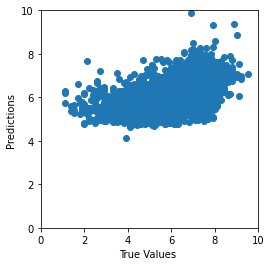

In [86]:
g=plt.scatter(ytest, yhat)
g.axes.set_xlabel('True Values ')
g.axes.set_ylabel('Predictions ')
g.axes.axis('equal')
g.axes.axis('square')
plt.ylim([0,  10])
plt.xlim([0,  10])

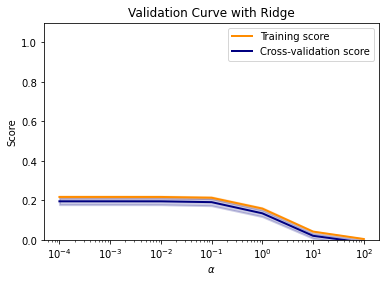

<Figure size 864x576 with 0 Axes>

[0.21779065 0.21779    0.21772911 0.21394588 0.15911586 0.04259656
 0.00509856]
[ 0.19573801  0.1957326   0.19562554  0.1914785   0.13500262  0.02127795
 -0.01348206]


In [98]:

param_range = [0.0001,0.001,0.01,0.1,1,10,100]
train_scores, test_scores = validation_curve(estimator=Ridge(normalize=True), 
                                             X=X, 
                                             y=y, 
                                             param_name="alpha",
                                             param_range=param_range,
                                             cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Ridge")
plt.xlabel(r"$\alpha$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.figure(figsize=(12,8))
plt.show()
print(train_scores_mean)
print(test_scores_mean)

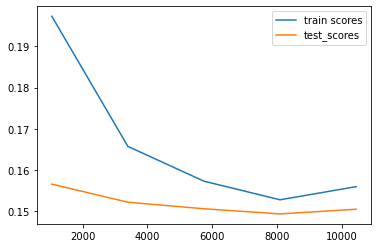

<Figure size 864x576 with 0 Axes>

In [99]:
estimator = Ridge(normalize=True)

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, Xtrain, ytrain, cv=30,return_times=True)

plt.plot(train_sizes,np.mean(train_scores,axis=1), label= 'train scores')
plt.plot(train_sizes,np.mean(test_scores,axis=1), label ='test_scores')
plt.legend(loc='best')
plt.figure(figsize=(12,8))
plt.show()

In [39]:
for i in range(len(alphaList)):
    print(f"{alphaList[i]}: {results[i]}")

0.0001: 8.031177116123008e-15
0.001: 8.031177448275401e-15
0.01: 8.031169838402337e-15
0.1: 8.031099134299455e-15
1: 8.01813315975281e-15
10: 7.894177600323875e-15
100: 7.777827463444486e-15


## 3.6 Lasso Regression

In [89]:


alphaList = [0.01,0.1,1,10,100]
results = []
for alpha in alphaList:
    model = Lasso(alpha=alpha)
    mses,models = kfold_validation(Xtrain,ytrain,model,5)
    yhat=models[np.argmin(mses)].predict(Xtest)
    results.append(np.mean(np.square(yhat-ytest)))
print(results)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.4434993267059326
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.2890005111694336
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.20201325416564941
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.19199609756469727
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.22350001335144043
[0.9632041015932816, 1.2021681963504771, 1.2453812290536508, 1.269617847071383, 1.2696177547693253]


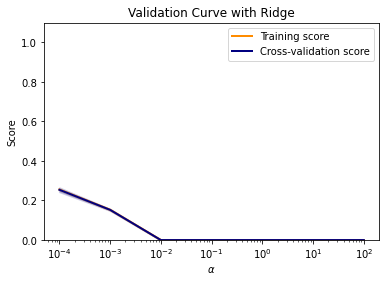

<Figure size 864x576 with 0 Axes>

[0.25524413 0.15291559 0.         0.         0.         0.
 0.        ]
[ 0.25397498  0.1524034  -0.00031136 -0.00031136 -0.00031136 -0.00031136
 -0.00031136]


In [90]:
param_range = [0.0001,0.001,0.01,0.1,1,10,100]
train_scores, test_scores = validation_curve(estimator=Lasso(normalize=True), 
                                             X=Xtrain, 
                                             y=ytrain, 
                                             param_name="alpha",
                                             param_range=param_range,
                                             cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Ridge")
plt.xlabel(r"$\alpha$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.figure(figsize=(12,8))
plt.show()
print(train_scores_mean)
print(test_scores_mean)

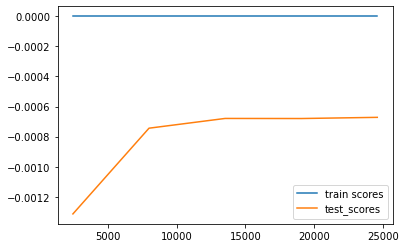

<Figure size 864x576 with 0 Axes>

In [91]:
estimator = Lasso(normalize=True)

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, Xtrain, ytrain, cv=30,return_times=True)

plt.plot(train_sizes,np.mean(train_scores,axis=1), label= 'train scores')
plt.plot(train_sizes,np.mean(test_scores,axis=1), label ='test_scores')
plt.legend(loc='best')
plt.figure(figsize=(12,8))
plt.show()

In [43]:
for i in range(len(alphaList)):
    print(f"{alphaList[i]}: {results[i]}")

0.0001: 8.031177116123008e-15
0.001: 8.031177448275401e-15
0.01: 8.031169838402337e-15
0.1: 8.031099134299455e-15
1: 8.01813315975281e-15
10: 7.894177600323875e-15
100: 7.777827463444486e-15


## 3.7 Random Forest

In [22]:
#reduced the param_grid iteratively
param_grid = {
    "max_depth": [3],
    "max_features": [25],
    "min_samples_split": [2],
    "min_samples_leaf": [3],
    "bootstrap": [True],
    #"criterion": ["mse","mae"], #takes ages to run
    "n_estimators": [175]
}

gs = grid_search.GridSearchCV(RandomForestRegressor(), param_grid=param_grid)
gs.fit(Xtrain,ytrain)
print(gs.best_params_)



/home/flo/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/cross_validation.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = (n // n_folds) * np.ones(n_folds, dtype=np.int)
/home/flo/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/cross_validation.py:103: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
De

In [23]:
 
model = RandomForestRegressor(**gs.best_params_)
mses,models = kfold_validation(Xtrain,ytrain,model)
yhat=models[np.argmin(mses)].predict(Xtest)
np.mean(np.square(yhat-ytest))


/home/flo/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/model_selection/_split.py:428: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = (n_samples // n_splits) * np.ones(n_splits, dtype=np.int)
/home/flo/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/model_selection/_split.py:108: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, u

1.2929339976793366

(0.0, 10.0)

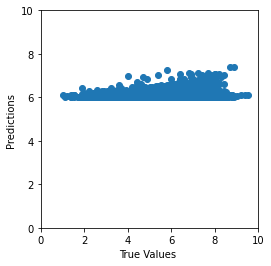

In [24]:
g=plt.scatter(ytest, yhat)
g.axes.set_xlabel('True Values ')
g.axes.set_ylabel('Predictions ')
g.axes.axis('equal')
g.axes.axis('square')
plt.ylim([0,  10])
plt.xlim([0,  10])

In [5]:


model = MLPRegressor(hidden_layer_sizes=(64,64,64,64))
mses,models = kfold_validation(Xtrain,ytrain,model)
yhat=models[np.argmin(mses)].predict(Xtest)
np.mean(np.square(yhat-ytest))


NameError: name 'MLPRegressor' is not defined

# 4. Conclusions

As can be seen our models performed worse than expected and do not have any predective capability that could be considered satisfactory. Nonetheless, at least our models do not seem to be overfitting. Our best performing model seams to be the regular linear regression model.

We assume that having more data columns would be beneficial in increasing the predictabiliy of our models. Especially a collumn which keeps track of the movies' budget could be beneficial, since it would let us derive a performance ratio (between the boxoffice and budget), which might strengthen our models' predictive capabilities. But alas budget information on movies is still scarce and not the norm.